[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akshita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Akshita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cpu
LSTM MODEL TESTING FOR DISASTER TWEET CLASSIFICATION
Loading real datasets...
Loading training data from C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final2\combinedSarcasmDataset.csv
Loading test data from C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final2\disasterTest.csv
Using 'predicted_label' as the label column
Training set shape: (7563, 6)
Test set shape: (3263, 4)
Class distribution in training set:
0    3009
2    2671
1    1883
Name: predicted_label, dtype: int64
Preprocessing training data...
Extracting rich text features...
Preprocessing test data...
Extracting rich text features...
Attempting to load GloVe embeddings from C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final\glove.6B.100d.txt\glove.6B.100d.txt
Loaded GloVe embeddings with 400000 words
Preparing data for LSTM...
Found embeddings for 8669/10000 words (86.69%)

TRAINING AND EVALUATING LSTM MODELS

Training Standard LSTM Model:
Training for 5 epochs...
Epoch 1/5 | Trai

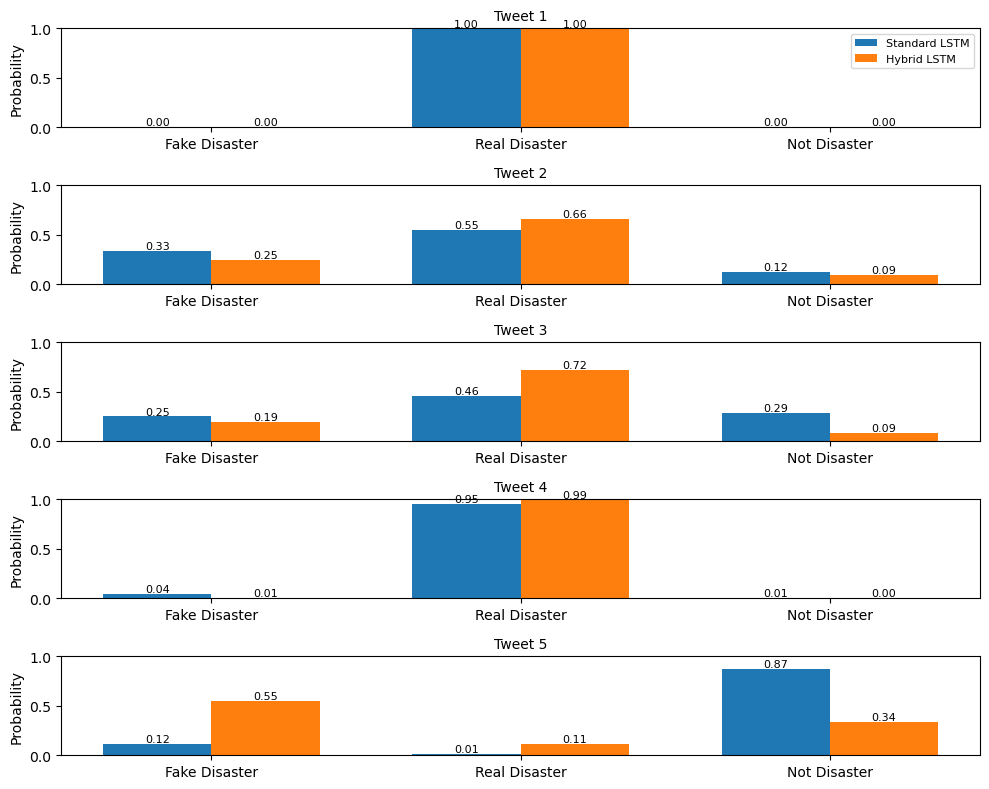


MODEL COMPARISON

Model Performance Comparison:
        Model  Accuracy  Precision   Recall  F1 Score  Training Time (s)
Standard LSTM  0.410035        1.0 0.410052  0.581613          19.528064
  Hybrid LSTM  0.524925        1.0 0.524977  0.688505          20.399617


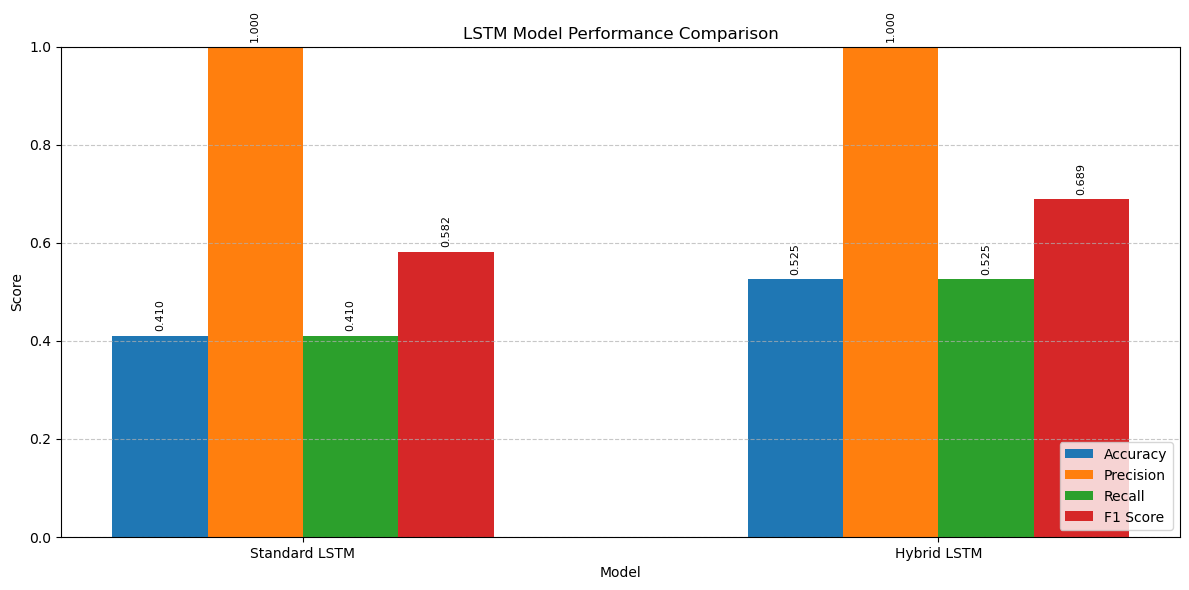

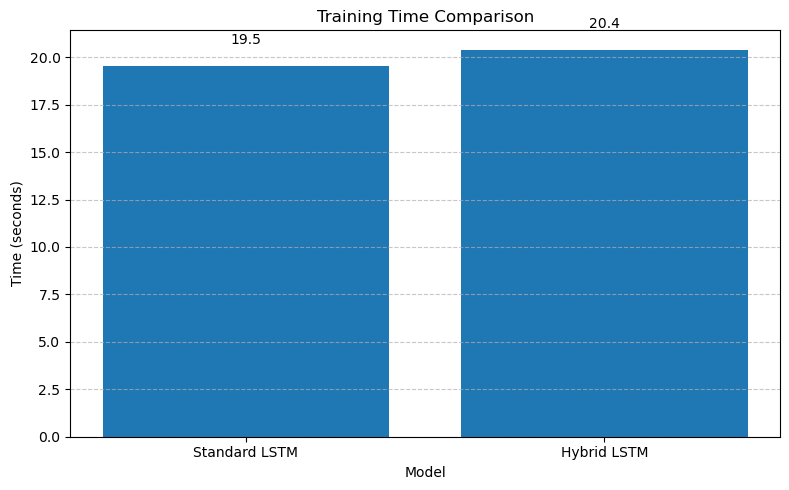

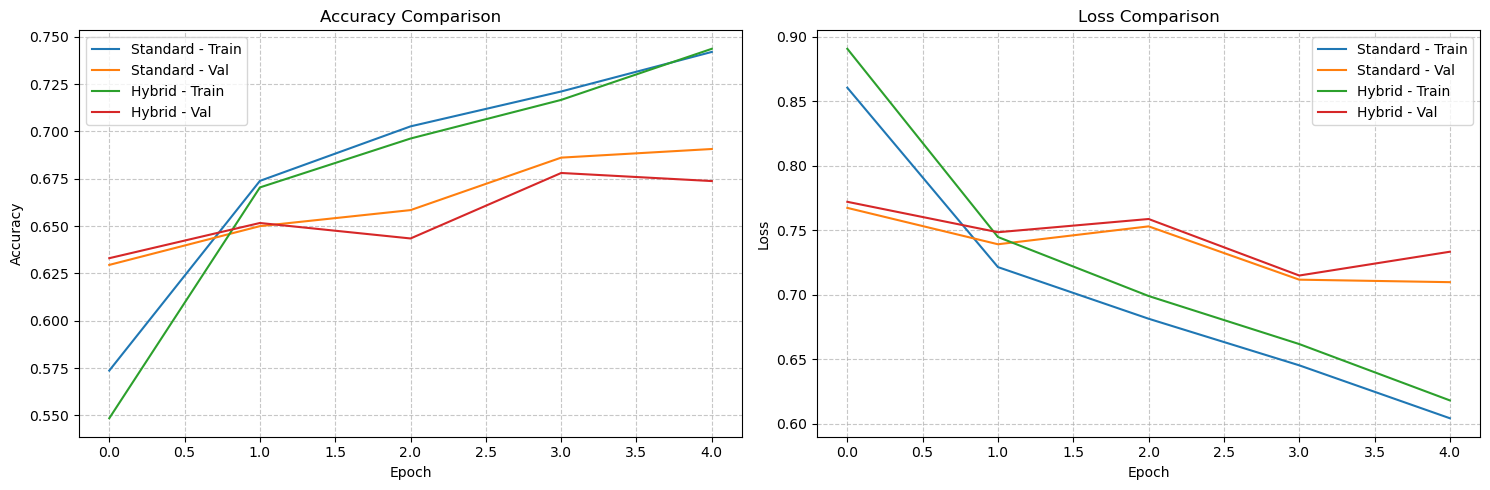


Best model: Hybrid LSTM with F1 Score = 0.6885

LSTM testing completed successfully!
Results saved to 'lstm_test_results' directory


In [1]:
# disaster_lstm_test_real_data.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import re
import string
import time
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Suppress warnings
warnings.filterwarnings('ignore')

# Create directories for output
os.makedirs('lstm_test_results', exist_ok=True)
os.makedirs('lstm_test_results/plots', exist_ok=True)
os.makedirs('lstm_test_results/models', exist_ok=True)

# Download required NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a simple word embedding when needed
def create_simple_embeddings(vocab_size=1000, embedding_dim=100):
    """Create simple word embeddings for testing"""
    print("Creating simple embeddings...")
    
    # Create vocabulary with common words and disaster-related terms
    base_vocab = ["the", "and", "a", "to", "of", "in", "is", "it", "that", "for", 
                 "disaster", "emergency", "fire", "flood", "earthquake", "hurricane",
                 "explosion", "crash", "accident", "help", "damage", "injured", "dead",
                 "rescue", "evacuation", "warning", "alert", "danger", "safe", "victim"]
    
    # Add more words to reach vocabulary size
    vocab = base_vocab.copy()
    for i in range(vocab_size - len(base_vocab)):
        vocab.append(f"word_{i}")
    
    # Create a KeyedVectors object
    model = KeyedVectors(embedding_dim)
    
    # Initialize vectors (use normal distribution for better properties)
    vectors = np.random.randn(len(vocab), embedding_dim).astype(np.float32)
    
    # Normalize vectors to unit length
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    
    # Add vectors to the model
    for i, word in enumerate(vocab):
        model.add_vector(word, vectors[i])
    
    print(f"Created simple embeddings with {len(model.key_to_index)} words")
    
    return model

# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin into a single string
    clean_text = ' '.join(tokens)
    
    return clean_text

# Extract rich text features
def extract_rich_text_features(text):
    """Extract rich text features like punctuation, capitalization, etc."""
    if pd.isna(text):
        return {
            'exclamation_count': 0,
            'question_count': 0,
            'uppercase_ratio': 0,
            'uppercase_word_count': 0,
            'punctuation_ratio': 0,
            'avg_word_length': 0
        }
    
    text = str(text)
    original_length = len(text)
    
    features = {}
    
    # Punctuation features
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    
    # Total punctuation count
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    features['punctuation_ratio'] = punctuation_count / original_length if original_length > 0 else 0
    
    # Word features
    words = text.split()
    word_count = len(words)
    
    # Capitalization features
    uppercase_words = [w for w in words if w.isupper() and len(w) > 1]
    features['uppercase_word_count'] = len(uppercase_words)
    features['uppercase_ratio'] = len(uppercase_words) / word_count if word_count > 0 else 0
    
    # Average word length
    if word_count > 0:
        features['avg_word_length'] = sum(len(w) for w in words) / word_count
    else:
        features['avg_word_length'] = 0
    
    return features

def enrich_dataframe_with_text_features(df, text_column='text'):
    """Add rich text features to DataFrame"""
    print("Extracting rich text features...")
    
    # Apply the feature extraction function to each tweet
    rich_features = []
    for text in df[text_column]:
        rich_features.append(extract_rich_text_features(text))
    
    # Convert list of dictionaries to DataFrame
    rich_features_df = pd.DataFrame(rich_features)
    
    # Combine with original DataFrame
    enriched_df = pd.concat([df.reset_index(drop=True), rich_features_df.reset_index(drop=True)], axis=1)
    
    return enriched_df

# Load and preprocess real datasets
def load_and_preprocess_data(train_path, test_path, sentiment_path=None):
    """Load and preprocess real datasets"""
    print("Loading real datasets...")
    
    # Load training data
    print(f"Loading training data from {train_path}")
    train_df = pd.read_csv(train_path)
    
    # Load test data
    print(f"Loading test data from {test_path}")
    test_df = pd.read_csv(test_path)
    
    # Check the label column
    label_col = 'predicted_label' if 'predicted_label' in train_df.columns else 'target'
    print(f"Using '{label_col}' as the label column")
    
    # Display dataset info
    print(f"Training set shape: {train_df.shape}")
    print(f"Test set shape: {test_df.shape}")
    
    # Display class distribution
    print("Class distribution in training set:")
    print(train_df[label_col].value_counts())
    
    # Clean text and extract features
    print("Preprocessing training data...")
    train_df['clean_text'] = train_df['text'].apply(clean_text)
    train_df = enrich_dataframe_with_text_features(train_df)
    
    print("Preprocessing test data...")
    test_df['clean_text'] = test_df['text'].apply(clean_text)
    test_df = enrich_dataframe_with_text_features(test_df)
    
    return train_df, test_df, label_col

# Prepare data for PyTorch LSTM
class Tokenizer:
    def __init__(self, texts, max_words=10000):
        self.max_words = max_words
        self.word_index = {"<PAD>": 0, "<OOV>": 1}  # PAD token and OOV (out of vocab) token
        self.index_word = {0: "<PAD>", 1: "<OOV>"}
        self.word_counts = {}
        self.num_words = 2  # Starting after PAD and OOV
        
        # Build vocabulary
        self.fit_on_texts(texts)
    
    def fit_on_texts(self, texts):
        """Build vocabulary from texts"""
        # Count words
        for text in texts:
            for word in text.split():
                if word in self.word_counts:
                    self.word_counts[word] += 1
                else:
                    self.word_counts[word] = 1
        
        # Sort by frequency and take top max_words
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        sorted_words = sorted_words[:self.max_words - 2]  # -2 for PAD and OOV
        
        # Create word_index
        for word, _ in sorted_words:
            self.word_index[word] = self.num_words
            self.index_word[self.num_words] = word
            self.num_words += 1
    
    def texts_to_sequences(self, texts):
        """Convert texts to sequences of integers"""
        sequences = []
        for text in texts:
            sequence = []
            for word in text.split():
                if word in self.word_index:
                    sequence.append(self.word_index[word])
                else:
                    sequence.append(1)  # OOV token
            sequences.append(sequence)
        return sequences

def prepare_data_for_lstm(train_df, test_df, embedding_model, label_col, test_size=0.2):
    """Prepare data for LSTM model"""
    print("Preparing data for LSTM...")
    
    # Create tokenizer
    tokenizer = Tokenizer(train_df['clean_text'].tolist(), max_words=10000)
    
    # Convert texts to sequences
    train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'].tolist())
    test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'].tolist())
    
    # Define max sequence length
    max_seq_length = 50
    
    # Pad sequences (manually)
    def pad_seq(sequences, max_len):
        padded = []
        for seq in sequences:
            if len(seq) > max_len:
                padded.append(seq[:max_len])
            else:
                padded.append(seq + [0] * (max_len - len(seq)))
        return padded
    
    train_padded = pad_seq(train_sequences, max_seq_length)
    test_padded = pad_seq(test_sequences, max_seq_length)
    
    # Extract labels
    train_labels = train_df[label_col].values
    if label_col in test_df.columns:
        test_labels = test_df[label_col].values
    else:
        test_labels = None
        print("Warning: Test set doesn't have labels. Using dummy labels for evaluation.")
        test_labels = np.zeros(len(test_df))
    
    # Extract rich text features
    rich_feature_cols = [
        'exclamation_count', 'question_count', 'uppercase_ratio', 
        'uppercase_word_count', 'punctuation_ratio', 'avg_word_length'
    ]
    
    # Scale rich features
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_df[rich_feature_cols].values)
    test_features = scaler.transform(test_df[rich_feature_cols].values)
    
    # Create embedding matrix
    embedding_dim = embedding_model.vector_size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Fill embedding matrix
    words_found = 0
    for word, i in tokenizer.word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
            words_found += 1
    
    print(f"Found embeddings for {words_found}/{len(tokenizer.word_index)} words ({words_found/len(tokenizer.word_index)*100:.2f}%)")
    
    # Split training data into train and validation
    train_seq, val_seq, train_lab, val_lab = train_test_split(
        train_padded, train_labels, test_size=test_size, stratify=train_labels, random_state=42
    )
    
    train_feat, val_feat = train_test_split(
        train_features, test_size=test_size, random_state=42
    )
    
    return {
        'tokenizer': tokenizer,
        'vocab_size': vocab_size,
        'embedding_matrix': embedding_matrix,
        'max_seq_length': max_seq_length,
        'train_sequences': train_seq,
        'val_sequences': val_seq,
        'test_sequences': test_padded,
        'train_labels': train_lab,
        'val_labels': val_lab,
        'test_labels': test_labels,
        'train_features': train_feat,
        'val_features': val_feat,
        'test_features': test_features,
        'scaler': scaler
    }

# PyTorch Dataset class
class TweetDataset(Dataset):
    def __init__(self, sequences, labels=None, features=None):
        self.sequences = sequences
        self.labels = labels
        self.features = features
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        if self.labels is not None and self.features is not None:
            return torch.LongTensor(sequence), torch.FloatTensor(self.features[idx]), self.labels[idx]
        elif self.labels is not None:
            return torch.LongTensor(sequence), self.labels[idx]
        elif self.features is not None:
            return torch.LongTensor(sequence), torch.FloatTensor(self.features[idx])
        else:
            return torch.LongTensor(sequence)

# LSTM Model Definition
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                n_layers=1, bidirectional=True, dropout=0.5, 
                padding_idx=0, embedding_weights=None):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
        # Initialize with pre-trained embeddings if provided
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.FloatTensor(embedding_weights))
            self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        # Calculate output dimension for LSTM
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Output layer
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        # text = [batch size, seq len]
        
        # Apply embedding layer
        embedded = self.embedding(text)
        # embedded = [batch size, seq len, embedding dim]
        
        # Apply LSTM
        lstm_output, (hidden, cell) = self.lstm(embedded)
        # lstm_output = [batch size, seq len, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        
        # Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        # hidden = [batch size, hidden dim * n directions]
        
        # Apply linear layer
        output = self.fc(hidden)
        # output = [batch size, output dim]
        
        return output

# Hybrid LSTM Model
class HybridLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, extra_features_dim, 
                output_dim, n_layers=1, bidirectional=True, dropout=0.5, 
                padding_idx=0, embedding_weights=None):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
        # Initialize with pre-trained embeddings if provided
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.FloatTensor(embedding_weights))
            self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        # Calculate output dimension for LSTM
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Extra features processing
        self.extra_features_fc = nn.Linear(extra_features_dim, 50)
        
        # Combine LSTM output with extra features
        self.combined_fc = nn.Linear(lstm_output_dim + 50, 100)
        
        # Output layer
        self.output_fc = nn.Linear(100, output_dim)
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, extra_features):
        # text = [batch size, seq len]
        # extra_features = [batch size, extra features dim]
        
        # Apply embedding layer
        embedded = self.embedding(text)
        # embedded = [batch size, seq len, embedding dim]
        
        # Apply LSTM
        lstm_output, (hidden, cell) = self.lstm(embedded)
        # lstm_output = [batch size, seq len, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        
        # Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        # hidden = [batch size, hidden dim * n directions]
        
        # Process extra features
        extra_features = torch.relu(self.extra_features_fc(extra_features))
        extra_features = self.dropout(extra_features)
        
        # Combine LSTM output with extra features
        combined = torch.cat([hidden, extra_features], dim=1)
        combined = torch.relu(self.combined_fc(combined))
        combined = self.dropout(combined)
        
        # Apply output layer
        output = self.output_fc(combined)
        # output = [batch size, output dim]
        
        return output

# Collate function for PyTorch DataLoader
def collate_fn(batch):
    if len(batch[0]) == 3:  # sequences, features, labels
        sequences = [item[0] for item in batch]
        features = torch.stack([item[1] for item in batch])
        labels = torch.LongTensor([item[2] for item in batch])
        
        # Pad sequences
        sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
        
        return sequences_padded, features, labels
    
    elif len(batch[0]) == 2:  # sequences, labels
        sequences = [item[0] for item in batch]
        labels = torch.LongTensor([item[1] for item in batch])
        
        # Pad sequences
        sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
        
        return sequences_padded, labels

# Create PyTorch dataloaders
def create_dataloaders(lstm_data, batch_size=32):
    """Create PyTorch DataLoader objects"""
    # Create datasets
    train_dataset = TweetDataset(
        lstm_data['train_sequences'], 
        lstm_data['train_labels'],
        lstm_data['train_features']
    )
    
    val_dataset = TweetDataset(
        lstm_data['val_sequences'], 
        lstm_data['val_labels'],
        lstm_data['val_features']
    )
    
    test_dataset = TweetDataset(
        lstm_data['test_sequences'], 
        lstm_data['test_labels'],
        lstm_data['test_features']
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )
    
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )
    
    return {
        'train_dataloader': train_dataloader,
        'val_dataloader': val_dataloader,
        'test_dataloader': test_dataloader
    }

# Training function
def train_lstm_model(model, dataloader, optimizer, criterion, device, is_hybrid=False):
    """Train LSTM model for one epoch"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in dataloader:
        # Handle batch based on its structure
        if len(batch) == 3:  # Hybrid data format
            text, features, labels = batch
            text = text.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            
            if is_hybrid:
                predictions = model(text, features)
            else:
                # If using standard model with hybrid data, just use text
                predictions = model(text)
                
        else:  # Standard data format (should be 2 items)
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(text)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted_classes = torch.max(predictions, 1)
        correct_predictions = (predicted_classes == labels).float()
        accuracy = correct_predictions.sum() / len(correct_predictions)
        
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

# Evaluation function
def evaluate_lstm_model(model, dataloader, criterion, device, is_hybrid=False):
    """Evaluate LSTM model"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Handle batch based on its structure
            if len(batch) == 3:  # Hybrid data format
                text, features, labels = batch
                text = text.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                # Forward pass
                if is_hybrid:
                    predictions = model(text, features)
                else:
                    # If using standard model with hybrid data, just use text
                    predictions = model(text)
                    
            else:  # Standard data format (should be 2 items)
                text, labels = batch
                text = text.to(device)
                labels = labels.to(device)
                
                # Forward pass
                predictions = model(text)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Calculate accuracy
            probabilities = torch.softmax(predictions, dim=1)
            _, predicted_classes = torch.max(predictions, 1)
            correct_predictions = (predicted_classes == labels).float()
            accuracy = correct_predictions.sum() / len(correct_predictions)
            
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()
            
            # Store predictions and labels for metrics calculation
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader), np.array(all_predictions), np.array(all_labels), np.array(all_probs)

# Train and evaluate both models
def train_and_evaluate_both_models(lstm_data, dataloaders, epochs=10):
    """Train and evaluate both standard and hybrid LSTM models"""
    print("\n" + "="*50)
    print("TRAINING AND EVALUATING LSTM MODELS")
    print("="*50)
    
    # Get data
    vocab_size = lstm_data['vocab_size']
    embedding_matrix = lstm_data['embedding_matrix']
    embedding_dim = embedding_matrix.shape[1]
    
    results = {}
    
    # 1. Train Standard LSTM
    print("\nTraining Standard LSTM Model:")
    
    # Initialize model
    standard_lstm = LSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=128,
        output_dim=3,  # Three classes
        n_layers=1,
        bidirectional=True,
        dropout=0.5,
        padding_idx=0,
        embedding_weights=embedding_matrix
    )
    
    standard_lstm = standard_lstm.to(device)
    
    # Set up optimizer and criterion
    optimizer = optim.Adam(standard_lstm.parameters())
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    print(f"Training for {epochs} epochs...")
    
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train_lstm_model(
            standard_lstm, 
            dataloaders['train_dataloader'], 
            optimizer, 
            criterion, 
            device,
            is_hybrid=False
        )
        
        # Validate
        val_loss, val_acc, _, _, _ = evaluate_lstm_model(
            standard_lstm, 
            dataloaders['val_dataloader'], 
            criterion, 
            device,
            is_hybrid=False
        )
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = standard_lstm.state_dict()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    standard_training_time = time.time() - start_time
    print(f"Training completed in {standard_training_time:.2f} seconds")
    
    # Load best model
    standard_lstm.load_state_dict(best_model_state)
    
    # Evaluate on test set
    test_loss, test_acc, test_predictions, test_labels, test_probs = evaluate_lstm_model(
        standard_lstm, 
        dataloaders['test_dataloader'], 
        criterion, 
        device,
        is_hybrid=False
    )
    
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    
    # Calculate additional metrics
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Standard LSTM - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Standard LSTM - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('lstm_test_results/plots/standard_lstm_history.png')
    plt.close()
    
    # Plot confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Standard LSTM - Confusion Matrix')
    plt.savefig('lstm_test_results/plots/standard_lstm_confusion_matrix.png')
    plt.close()
    
    # Save model
    torch.save(standard_lstm.state_dict(), 'lstm_test_results/models/standard_lstm.pt')
    
    # Store results
    results['Standard LSTM'] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': standard_training_time,
        'confusion_matrix': cm
    }
    
    # 2. Train Hybrid LSTM
    print("\nTraining Hybrid LSTM Model:")
    
    # Initialize model
    hybrid_lstm = HybridLSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=128,
        extra_features_dim=lstm_data['train_features'].shape[1],
        output_dim=3,  # Three classes
        n_layers=1,
        bidirectional=True,
        dropout=0.5,
        padding_idx=0,
        embedding_weights=embedding_matrix
    )
    
    hybrid_lstm = hybrid_lstm.to(device)
    
    # Set up optimizer and criterion
    optimizer = optim.Adam(hybrid_lstm.parameters())
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    print(f"Training for {epochs} epochs...")
    
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train_lstm_model(
            hybrid_lstm, 
            dataloaders['train_dataloader'], 
            optimizer, 
            criterion, 
            device,
            is_hybrid=True
        )
        
        # Validate
        val_loss, val_acc, _, _, _ = evaluate_lstm_model(
            hybrid_lstm, 
            dataloaders['val_dataloader'], 
            criterion, 
            device,
            is_hybrid=True
        )
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = hybrid_lstm.state_dict()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    hybrid_training_time = time.time() - start_time
    print(f"Training completed in {hybrid_training_time:.2f} seconds")
    
    # Load best model
    hybrid_lstm.load_state_dict(best_model_state)
    
    # Evaluate on test set
    test_loss, test_acc, test_predictions, test_labels, test_probs = evaluate_lstm_model(
        hybrid_lstm, 
        dataloaders['test_dataloader'], 
        criterion, 
        device,
        is_hybrid=True
    )
    
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    
    # Calculate additional metrics
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Hybrid LSTM - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Hybrid LSTM - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('lstm_test_results/plots/hybrid_lstm_history.png')
    plt.close()
    
    # Plot confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Hybrid LSTM - Confusion Matrix')
    plt.savefig('lstm_test_results/plots/hybrid_lstm_confusion_matrix.png')
    plt.close()
    
    # Save model
    torch.save(hybrid_lstm.state_dict(), 'lstm_test_results/models/hybrid_lstm.pt')
    
    # Store results
    results['Hybrid LSTM'] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': hybrid_training_time,
        'confusion_matrix': cm
    }
    
    return results

# Compare model performance
def compare_models(results):
    """Compare performance of both models"""
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    # Create comparison DataFrame
    comparison_data = []
    
    for model_name, model_results in results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': model_results['test_acc'],
            'Precision': model_results['precision'],
            'Recall': model_results['recall'],
            'F1 Score': model_results['f1'],
            'Training Time (s)': model_results['training_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Print table
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Create comparison bar chart
    plt.figure(figsize=(12, 6))
    
    # Set up positions
    models = comparison_df['Model']
    x = np.arange(len(models))
    width = 0.15
    
    # Plot bars for each metric
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, metric in enumerate(metrics):
        plt.bar(x + (i - 1.5) * width, comparison_df[metric], width, label=metric, color=colors[i])
    
    # Add value labels on bars
    for i, metric in enumerate(metrics):
        for j, value in enumerate(comparison_df[metric]):
            plt.text(j + (i - 1.5) * width, value + 0.01, f'{value:.3f}', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Customize plot
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('LSTM Model Performance Comparison')
    plt.xticks(x, models)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('lstm_test_results/plots/model_comparison.png')
    plt.show()
    
    # Create training time comparison
    plt.figure(figsize=(8, 5))
    bars = plt.bar(comparison_df['Model'], comparison_df['Training Time (s)'])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}', ha='center', va='bottom')
    
    plt.title('Training Time Comparison')
    plt.xlabel('Model')
    plt.ylabel('Time (seconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('lstm_test_results/plots/training_time_comparison.png')
    plt.show()
    
    # Compare learning curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(results['Standard LSTM']['train_accs'], label='Standard - Train')
    plt.plot(results['Standard LSTM']['val_accs'], label='Standard - Val')
    plt.plot(results['Hybrid LSTM']['train_accs'], label='Hybrid - Train')
    plt.plot(results['Hybrid LSTM']['val_accs'], label='Hybrid - Val')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(results['Standard LSTM']['train_losses'], label='Standard - Train')
    plt.plot(results['Standard LSTM']['val_losses'], label='Standard - Val')
    plt.plot(results['Hybrid LSTM']['train_losses'], label='Hybrid - Train')
    plt.plot(results['Hybrid LSTM']['val_losses'], label='Hybrid - Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('lstm_test_results/plots/learning_curves_comparison.png')
    plt.show()
    
    # Find best model
    best_model_row = comparison_df.loc[comparison_df['F1 Score'].idxmax()]
    best_model = best_model_row['Model']
    best_f1 = best_model_row['F1 Score']
    
    print(f"\nBest model: {best_model} with F1 Score = {best_f1:.4f}")
    
    # Save comparison results
    comparison_df.to_csv('lstm_test_results/lstm_model_comparison.csv', index=False)

# Sample prediction function
def predict_sample_tweets(standard_lstm, hybrid_lstm, lstm_data):
    """Make predictions on sample tweets"""
    print("\n" + "="*50)
    print("SAMPLE TWEET PREDICTIONS")
    print("="*50)
    
    # Sample tweets
    sample_tweets = [
        "BREAKING: Massive earthquake hits San Francisco, buildings collapsed.",
        "This party is on fire! Everyone's having a blast!",
        "Students flood campus for first day of classes.",
        "Hurricane Laura makes landfall as Category 4 storm with 150 mph winds.",
        "My heart crashed when I saw the price of the new iPhone."
    ]
    
    # Expected classes
    expected_classes = [1, 0, 2, 1, 0]
    
    # Clean tweets
    clean_tweets = [clean_text(tweet) for tweet in sample_tweets]
    
    # Convert to sequences
    tokenizer = lstm_data['tokenizer']
    sequences = [tokenizer.texts_to_sequences([tweet])[0] for tweet in clean_tweets]
    
    # Pad sequences
    max_seq_length = lstm_data['max_seq_length']
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_seq_length:
            padded_sequences.append(seq[:max_seq_length])
        else:
            padded_sequences.append(seq + [0] * (max_seq_length - len(seq)))
    
    # Extract features for hybrid model
    features = []
    for tweet in sample_tweets:
        rich_features = extract_rich_text_features(tweet)
        features.append([
            rich_features['exclamation_count'],
            rich_features['question_count'],
            rich_features['uppercase_ratio'],
            rich_features['uppercase_word_count'],
            rich_features['punctuation_ratio'],
            rich_features['avg_word_length']
        ])
    
    # Scale features
    scaled_features = lstm_data['scaler'].transform(features)
    
    # Convert to tensors
    sequences_tensor = torch.LongTensor(padded_sequences).to(device)
    features_tensor = torch.FloatTensor(scaled_features).to(device)
    
    # Make predictions with standard LSTM
    standard_lstm.eval()
    with torch.no_grad():
        standard_outputs = standard_lstm(sequences_tensor)
        standard_probs = torch.softmax(standard_outputs, dim=1)
        standard_preds = torch.argmax(standard_probs, dim=1)
    
    # Make predictions with hybrid LSTM
    hybrid_lstm.eval()
    with torch.no_grad():
        hybrid_outputs = hybrid_lstm(sequences_tensor, features_tensor)
        hybrid_probs = torch.softmax(hybrid_outputs, dim=1)
        hybrid_preds = torch.argmax(hybrid_probs, dim=1)
    
    # Print results
    print("\nSample Tweet Predictions:")
    print(f"{'Tweet':<60} | {'Expected':<10} | {'Standard LSTM':<15} | {'Hybrid LSTM':<15}")
    print("-" * 105)
    
    class_names = ["Fake Disaster", "Real Disaster", "Not Disaster"]
    
    for i, tweet in enumerate(sample_tweets):
        expected = class_names[expected_classes[i]]
        standard_pred = class_names[standard_preds[i].item()]
        standard_conf = standard_probs[i][standard_preds[i]].item()
        hybrid_pred = class_names[hybrid_preds[i].item()]
        hybrid_conf = hybrid_probs[i][hybrid_preds[i]].item()
        
        # Truncate tweet if too long
        display_tweet = tweet[:57] + "..." if len(tweet) > 60 else tweet
        
        print(f"{display_tweet:<60} | {expected:<10} | {standard_pred:<10} ({standard_conf:.2f}) | {hybrid_pred:<10} ({hybrid_conf:.2f})")
    
    # Create prediction visualizations
    plt.figure(figsize=(10, 8))
    
    for i, tweet in enumerate(sample_tweets):
        plt.subplot(5, 1, i+1)
        
        # Standard LSTM probabilities
        standard_prob_values = standard_probs[i].cpu().numpy()
        
        # Hybrid LSTM probabilities
        hybrid_prob_values = hybrid_probs[i].cpu().numpy()
        
        # Set up positions
        x = np.arange(3)
        width = 0.35
        
        # Plot bars
        plt.bar(x - width/2, standard_prob_values, width, label='Standard LSTM')
        plt.bar(x + width/2, hybrid_prob_values, width, label='Hybrid LSTM')
        
        # Add text labels
        for j, v in enumerate(standard_prob_values):
            plt.text(j - width/2, v + 0.02, f'{v:.2f}', ha='center', fontsize=8)
        
        for j, v in enumerate(hybrid_prob_values):
            plt.text(j + width/2, v + 0.02, f'{v:.2f}', ha='center', fontsize=8)
        
        # Customize plot
        plt.ylabel('Probability')
        plt.title(f'Tweet {i+1}', fontsize=10)
        plt.xticks(x, class_names)
        plt.ylim(0, 1)
        
        # Only add legend to the first subplot to avoid clutter
        if i == 0:
            plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig('lstm_test_results/plots/sample_prediction_probabilities.png')
    plt.show()

# Main function
def main():
    print("="*70)
    print("LSTM MODEL TESTING FOR DISASTER TWEET CLASSIFICATION")
    print("="*70)
    
    # Set file paths for your datasets
    train_path = r"C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final2\combinedSarcasmDataset.csv"
    test_path = r"C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final2\disasterTest.csv"
    
    # Load and preprocess real datasets
    train_df, test_df, label_col = load_and_preprocess_data(train_path, test_path)
    
    # Create or load word embeddings
    try:
        # Try to load GloVe embeddings
        glove_path = r"C:\Users\Akshita\Desktop\classes_ug\sem4\mlpr\project\final\glove.6B.100d.txt\glove.6B.100d.txt"
        print(f"Attempting to load GloVe embeddings from {glove_path}")
        
        # Check if GloVe file exists
        if os.path.exists(glove_path):
            from gensim.scripts.glove2word2vec import glove2word2vec
            w2v_path = f"{glove_path}.word2vec"
            
            # Convert to word2vec format if needed
            if not os.path.exists(w2v_path):
                print("Converting GloVe to Word2Vec format...")
                glove2word2vec(glove_path, w2v_path)
            
            # Load the embeddings
            embedding_model = KeyedVectors.load_word2vec_format(w2v_path)
            print(f"Loaded GloVe embeddings with {len(embedding_model.key_to_index)} words")
        else:
            print("GloVe file not found. Creating simple embeddings...")
            embedding_model = create_simple_embeddings(vocab_size=5000, embedding_dim=100)
    except Exception as e:
        print(f"Error loading embeddings: {str(e)}")
        print("Creating simple embeddings instead...")
        embedding_model = create_simple_embeddings(vocab_size=5000, embedding_dim=100)
    
    # Prepare data for LSTM
    lstm_data = prepare_data_for_lstm(train_df, test_df, embedding_model, label_col)
    
    # Create dataloaders
    dataloaders = create_dataloaders(lstm_data)
    
    # Train and evaluate models
    results = train_and_evaluate_both_models(lstm_data, dataloaders, epochs=5)
    
    # Get trained models
    standard_lstm = LSTMClassifier(
        vocab_size=lstm_data['vocab_size'],
        embedding_dim=lstm_data['embedding_matrix'].shape[1],
        hidden_dim=128,
        output_dim=3,
        n_layers=1,
        bidirectional=True,
        dropout=0.5,
        padding_idx=0,
        embedding_weights=lstm_data['embedding_matrix']
    )
    standard_lstm.load_state_dict(torch.load('lstm_test_results/models/standard_lstm.pt'))
    standard_lstm = standard_lstm.to(device)
    
    hybrid_lstm = HybridLSTMClassifier(
        vocab_size=lstm_data['vocab_size'],
        embedding_dim=lstm_data['embedding_matrix'].shape[1],
        hidden_dim=128,
        extra_features_dim=lstm_data['train_features'].shape[1],
        output_dim=3,
        n_layers=1,
        bidirectional=True,
        dropout=0.5,
        padding_idx=0,
        embedding_weights=lstm_data['embedding_matrix']
    )
    hybrid_lstm.load_state_dict(torch.load('lstm_test_results/models/hybrid_lstm.pt'))
    hybrid_lstm = hybrid_lstm.to(device)
    
    # Predict sample tweets
    predict_sample_tweets(standard_lstm, hybrid_lstm, lstm_data)
    
    # Compare models
    compare_models(results)
    
    print("\nLSTM testing completed successfully!")
    print(f"Results saved to 'lstm_test_results' directory")

if __name__ == "__main__":
    main()